### Empezamos a trabajar aquí

In [18]:
!python3 -m pip install -q astroquery spiceypy numpy matplotlib pandas
!wget -O naif0012.tls https://naif.jpl.nasa.gov/pub/naif/generic_kernels/lsk/naif0012.tls &>/dev/null

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import spiceypy as spy
from astroquery.jplhorizons import Horizons
from urllib import request
import json
from collections import OrderedDict as odict

In [10]:
spy.furnsh('naif0012.tls')

In [11]:
html=request.urlopen(f"https://ssd-api.jpl.nasa.gov/sbdb.api?sstr=2021eu&cov=mat")
json_data=json.loads(html.read().decode())
json_data

{'object': {'neo': True,
  'orbit_class': {'name': 'Apollo', 'code': 'APO'},
  'pha': False,
  'spkid': '54130040',
  'kind': 'au',
  'orbit_id': '9',
  'fullname': '(2021 EU)',
  'des': '2021 EU',
  'prefix': None},
 'signature': {'source': 'NASA/JPL Small-Body Database (SBDB) API',
  'version': '1.3'},
 'orbit': {'source': 'JPL',
  'moid_jup': '1.78',
  't_jup': '3.374',
  'condition_code': '8',
  'not_valid_before': None,
  'rms': '0.36',
  'model_pars': [],
  'orbit_id': '9',
  'producer': 'Otto Matic',
  'first_obs': '2021-03-02',
  'soln_date': '2022-06-30 05:55:45',
  'two_body': None,
  'epoch': '2459279.5',
  'elements': [{'value': '0.727',
    'sigma': '0.00087',
    'name': 'e',
    'title': 'eccentricity',
    'label': 'e',
    'units': None},
   {'value': '2.07',
    'sigma': '0.0056',
    'name': 'a',
    'title': 'semi-major axis',
    'label': 'a',
    'units': 'au'},
   {'value': '0.565',
    'sigma': '0.00027',
    'name': 'q',
    'title': 'perihelion distance',
    

In [12]:
rad=180/np.pi
deg=1/rad
AU=149597870.693 #km 
mu=132712440023.310 #km^3/s^2

In [13]:
Cov=np.array(json_data["orbit"]["covariance"]["data"],dtype=float)
Cov_label=json_data["orbit"]["covariance"]["labels"]
t=float(json_data["orbit"]["epoch"])
mu=132712440023.310 #km^3/s^2
Cov,Cov_label

(array([[ 7.61e-07, -2.40e-07,  2.52e-05, -1.35e-06,  2.50e-06,  4.02e-06],
        [-2.40e-07,  7.54e-08, -7.93e-06,  4.23e-07, -7.87e-07, -1.26e-06],
        [ 2.52e-05, -7.93e-06,  8.33e-04, -4.45e-05,  8.28e-05,  1.33e-04],
        [-1.35e-06,  4.23e-07, -4.45e-05,  2.38e-06, -4.44e-06, -7.10e-06],
        [ 2.50e-06, -7.87e-07,  8.28e-05, -4.44e-06,  8.32e-06,  1.32e-05],
        [ 4.02e-06, -1.26e-06,  1.33e-04, -7.10e-06,  1.32e-05,  2.12e-05]]),
 ['e', 'q', 'tp', 'node', 'peri', 'i'])

In [14]:
nlen=len(json_data["orbit"]["elements"])
elnames=[]
elements=odict()
for i in range(nlen):
  element=json_data["orbit"]["elements"][i]
  elements[element["name"]]=odict()
  for prop in element.keys():
    try:
      elements[element["name"]][prop]=float(element[prop])
    except:
      pass

for elname in elements.keys():
  element=elements[elname]
  print(f"Elemento {elname} = {element['value']} +/- {element['sigma']**2}")

means=[elements['e']['value'],elements['q']['value'],elements['tp']['value'],elements['om']['value'],elements['w']['value'],elements['i']['value']]
means

Elemento e = 0.727 +/- 7.569e-07
Elemento a = 2.07 +/- 3.136e-05
Elemento q = 0.565 +/- 7.29e-08
Elemento i = 3.84 +/- 2.116e-05
Elemento om = 158.0 +/- 2.25e-06
Elemento w = 269.0 +/- 8.409999999999999e-06
Elemento ma = 17.2 +/- 0.0064
Elemento tp = 2459227.382 +/- 0.0008410000000000001
Elemento per = 1090.0 +/- 19.360000000000003
Elemento n = 0.33 +/- 1.69e-06
Elemento ad = 3.58 +/- 9.409e-05


[0.727, 0.565, 2459227.382, 158.0, 269.0, 3.84]

### Idea 1: Hacer la Gaussiana Multivariada y con los valores obtenidos hallar M.


In [15]:
data=np.random.multivariate_normal(means,Cov,1000)

/tmp/ipykernel_3259/3345734706.py:1: RuntimeWarning: covariance is not positive-semidefinite.
  data=np.random.multivariate_normal(means,Cov,1000)


In [20]:
e=data[:,0];q=data[:,1];tp=data[:,2];node=data[:,3];peri=data[:,4];inc=data[:,5]

t0=float(json_data["orbit"]["epoch"])
et0=spy.unitim(t0,"JDTDB","ET")

a=(q/(1-e))*AU
n=np.sqrt(mu/a**3)
#n=np.rad2deg(n)
#n*86400
tps=np.array([spy.unitim(t,"JDTDB","ET") for t in tp])
M=n*(t-tps)
Ms=np.mod(M,2*np.pi)

et=spy.str2et("2023-03-11.35 UTC")

Asteroid=[]
for i in range(len(e)):
  Asteroid.append(spy.conics([q[i]*AU,e[i],inc[i]*deg,node[i]*deg,peri[i]*deg,Ms[i],et0,mu],et0))
Asteroid=np.array(Asteroid)
#print(f"e ={e}\nq={q}\ntp={tp}\nnode={node}\nperi={peri}\nM={Ms}\ni={inc}")
et0, et

(668260800.0, 731764869.185513)

In [21]:
Epoch=spy.unitim(et,"ET","JDTDB")
data_tierra=Horizons(id="399",location="@10",epochs=Epoch).vectors()
rE=np.array(data_tierra.to_pandas().loc[0,["x","y","z"]].astype("float"))*AU


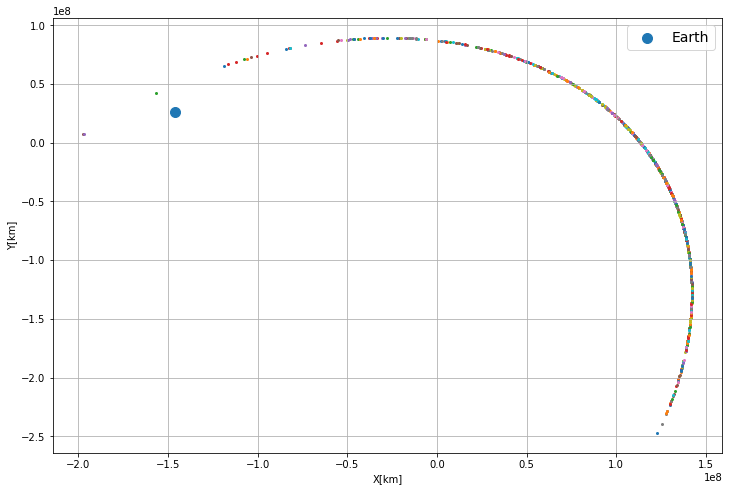

In [22]:
fig=plt.figure(figsize=(12,8))
ax1=fig.add_subplot(111)
#ax.scatter(rE[0],rE[1],rE[2],marker="o",s=64, label="Earth")
ax1.scatter(rE[0],rE[1],marker="o",s=10**2, label="Earth")
ax1.set(xlabel="X[km]",ylabel="Y[km]")
for k in range(len(Asteroid)):
  #ax.scatter(Asteroid[k][:3][0],Asteroid[k][:3][1],Asteroid[k][:3][2], s=2**2)
  ax1.scatter(Asteroid[k][:3][0],Asteroid[k][:3][1], s=2**2)

plt.legend(fontsize=14)
plt.grid()

In [13]:
#"{:e}".format(abs(np.linalg.norm(Asteroid[0][:3])-np.linalg.norm(Asteroid[1][:3])))
np.std(a/AU)

NameError: name 'a' is not defined